In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import nivapy
import seaborn as sn

sn.set_context('poster')

# Spatio-temporal data processing using Oracle and PostGIS

I need to gather data to support development of a "metals" module for the new [NOPE model](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model.ipynb). Anders Finstad has supplied a potentially useful dataset covering nearly 5000 lake catchments across the whole of Fennoscandia. This dataset is large (about 1 GB) and includes spatial information represented as hexadecimal-encoded Well-Known Binary (WKB). The raw data are here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals\Raw_Datasets\ecco_biwa_db_storage.csv

In theory, NIVA should have the original Norwegian data from the same survey somewhere in our system, as I believe we were responsible for the Norwegian fieldwork campaign back in the mid-1990s. The first step is therefore to try to link the spatial data supplied by Anders to the information we already have in RESA. This seems like a good opportunity to try some improved spatial integration using `NivaPy`.

## 1. Connect to databases

I have improved `nivapy.da.connect()` so that it now securely requests user credentials. I'vr also added options for connecting to either (i) the NIVABASE or (ii) my local PostGIS installation.

In [2]:
# Connect to nivabase
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


In [3]:
# Connect to postgis
pg_eng = nivapy.da.connect(src='postgres')

Username: ········
Password: ········
Connection successful.


## 2. Resample and extract vector data

I've loaded the information from Anders into PostGIS and converted the hex-encoded WKB to PostGIS' `MULTIPOLYGON` geometry type. QGIS provides a nice interface for connecting directly to PostGIS databases and exploring this data - see the QGIS file here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals\Raw_Datasets\raw_metals_datasets.qgs

Unfortunately, QGIS cannot connect to the NIVABASE, so this doesn't help with linking NIVA water chemistry to the spatial data. Instead, I can extract the data from PostGIS and work with it in Python. However, because the dataset is large (~1 GB), trying to load it into my browser is not an option. 

The code below uses PostGIS' `ST_SimplifyPreserveTopology` to create a lower-resolution version of the dataset. It also extracts only the polygons located within Norway, which should keep file sizes manageable. Downsampling is achieved using the [Douglas-Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm), but with the additional constraint that topological relationships are presereved. I have allowed vector nodes to be moved by up to a maximum of 1 km during the simplification process.

In [4]:
# Extract Al data 
sql = ("SELECT ST_SimplifyPreserveTopology(geom2, 1000) AS geom, ral "
       "FROM niva_work.nope_metals.ecco_biwa "
       "WHERE nation = 'Norway'")
crs = {'init': 'epsg:32633'} # UTM Zone 33N
gdf = gpd.GeoDataFrame.from_postgis(sql, geom_col='geom', crs=crs, con=pg_eng)

print 'Total number of Norwegian catchments:', len(gdf)

gdf.head()

Total number of Norwegian catchments: 990


,geom,ral
0,"POLYGON ((311315 6571695, 310835 6572165, 3113...",20.0
1,"POLYGON ((289485 6645005, 287475 6646655, 2888...",27.0
2,"POLYGON ((2395 6794975, 2345 6796625, 3375 679...",49.0
3,"POLYGON ((63105 6638725, 55035 6643375, 58735 ...",-10.0
4,"POLYGON ((374285 7105335, 374105 7105645, 3742...",12.0


## 3. Choropleth map

I've added a new function to `nivapy.spatial` for creating choropleth maps. The map below shows each catchment coloured according to the concentration of reactive aluminium.

In [5]:
# Choropleth of Al concs
map1 = nivapy.spatial.choropleth_from_gdf(gdf, 'ral', fill_opacity=0.5,
                                          legend_name='Reactive Al (ug/l)')
map1

## 4. Search the NIVABASE

Next, I want to search the NIVABASE for corresponding data. It's a long time ago, but Øyvind thinks the relevant project was probably called something like `Regionalundersøkelse`.

In [6]:
# Search projects
prj_df = nivapy.da.search_projects("project_name LIKE 'Regional%'", ora_eng)
prj_df

,project_id,project_number,project_name,contact_person,project_description
0,27,None,Regionalundersøkelse 1995,RESA,Tusensjøersundersøkelsen 1995 med etterfølgend...
1,81,None,Regionalundersøkelse 1986,None,Tusensjøers undersøkelsen 1986 samt nyere data...


This looks promising. Let's get the stations from the 1995 survey.

In [7]:
# Get stations for 1995
stn_df = nivapy.da.select_project_stations([27,], ora_eng)

print 'Number of stations:', len(stn_df)
stn_df.head()

Number of stations: 1006


,station_id,station_code,station_name,latitude,longitude,altitude
0,115,831-501,BrÃ¥rvatn,59.294921,7.727118,902.0
1,116,1640-603,Tufsingen,62.612294,11.876558,781.0
2,125,2030-607,St.Valvatnet,69.694975,30.656211,157.0
3,135,1228-501,Steinavatn,59.859877,6.578783,1047.0
4,166,1018-4,Kleivsetvannet,58.119559,7.664899,93.0


This looks promising: there are 1006 stations in the NIVABASE and roughly the same number (990) in Anders Finstad's spatial dataset.

I have also updated `nivapy.spatial.quickmap()` to also maps to be combined. This needs further work to make it properly robust, but it's a useful start. The code below combined the choropleth map with the station data.

In [8]:
# Add station locs to choropleth
map2 = nivapy.spatial.quickmap(stn_df, popup='code', map_obj=map1)
map2

Zooming it, it's pretty obvious that the data in the NIVABASE matches the lake catchments in Anders' dataset, which is a good result.

## 5. Extract time series

As a final data exploration step, I'd like to see how much temporal data we have for these sites.

In [9]:
# Container for results
df_list = []

# Loop over stations
for stn_id in stn_df['station_id']:
    # Get all Al data
    wc_df, dup_df = nivapy.da.extract_water_chem(stn_id, ['Al',],
                                                 '1980-01-01', 
                                                 '2015-12-31',
                                                 ora_eng,
                                                 plot=False)
    
    # Tidy
    wc_df['station_id'] = stn_id
    wc_df.reset_index(inplace=True)
    df_list.append(wc_df)  

# Combine output
wc_df = pd.concat(df_list, axis=0)

#  Annual means for each site
wc_df['year'] = wc_df['sample_date'].dt.year
an_df = wc_df.groupby(['year', 'station_id']).mean()

an_df.head(10)

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.



Al_µg/l
year station_id           
1981 115         110.00000
     3347        200.00000
     3544         10.00000
1986 39          155.00000
     166         316.00000
     3359        157.00000
     15712       153.00000
     17988        83.00000
     18158       242.00000
2004 14           27.97975

Not that there are some problems with duplicates in the database. These should be tidied up at some point.

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


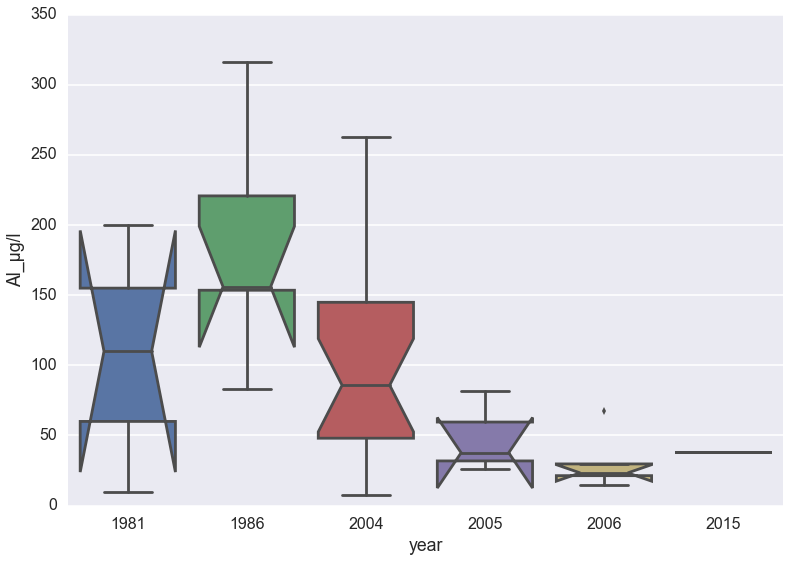

In [10]:
# Boxplots for each year
an_df.reset_index(inplace=True)
del an_df['station_id']
sn.boxplot(data=an_df, x='year', y=u'Al_µg/l', notch=True)

It's pretty clear that Al concentrations have decreased steadily since the late 1980s, which is a sign of recovery from acidification. It's strange that none of the data actually come from 1995 though - **need to ask Øyvind for more details regarding what this project actually involved**.